# Описание проекта
На основе уже имеющихся данных проведём анализ активности пользователей, выявим их предпочтения, сделаем сегментацию. 

## Цель проекта: 
Изучить данные, привести их в пригодный для анализа формат.
Обнаружить в них значимые инсайты.
Данные длинного формата нужно привести в данные широкого формата.
Исследовать голосующую аудиторию проекта (провести предварительный EDA по данным). Выбрать параметры для сегментации, разделить пользователей на сегменты и изучить данные подробнее в разрезе сегментов. 

## Механика выборов
Выборы проводятся каждые полгода.

Побеждают кандидаты, которые набирают ⅔ голосов “за”. 

Выбирают комиссию (ареопаг), которая обладает особыми правами. Например решать споры о банах/разбанах пользователей или статей.

Одна из гипотез, которую можно проверить — то что голосование проходит активнее за тех кандидатов, результаты которых близки к этому пороговому значению.

Для каждых выборов можно нарисовать таймлайн, каковы были результаты кандидатов в каждый момент времени (доля голосов “за” среди общего числа голосов).

# Описание данных

- `stats` — информация о пользователях
- `stats.Edits` - Количество правок
- `stats.Reverts` - Количество отмен чужих правок
- `stats.Log` - Количество иных действий
- `stats.Diff` - Добавленное минус удалённое
- `stats.Volume` - Общий объём добавленного
- `stats.Tot size` - Накопленная сумма добавленного
- `stats.Time` - Время онлайн
- `stats.Speed` - Скорость (количество правок в единицу времени)
- `stats.User` - Ник пользователя
- `stats.txt` - Дата в текстовом формате




- `votes` — информация о голосовании
- `votes.voter` - Голосующий
- `votes.can_vote` - Проходит по критериям
- `votes.time` - Время голоса
- `votes.candidate` - Кандидат, по которому голос
- `votes.n` - Номер выборов, с дробными частями - довыборы
- `votes.vote` - Голос, 1 - за, -1 - против
- `votes.lt` - Суток от начала текущих выборов

<a id="start"></a>
# Загрузка и подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta
import numpy as np
import datetime as dt


# зададим стиль по-умолчанию для графиков
plt.style.use('ggplot')

In [2]:
# загружаем датасеты из файлов
import gdown

try:
    stats = pd.read_excel('../datasets/wiki/stats.xlsx')
    votes = pd.read_excel('../datasets/wiki/votes.xlsx')
except:
    url_stats = 'https://drive.google.com/uc?id=1JI0yWK4AqHeQdUqHTJOt0Rr7ZjdQnThX' 
    stats_path = 'stats.read_excel'
    url_votes = 'https://drive.google.com/uc?id=17gm4aPW6pZog5Z4q5g9FrHA42cTAWpc6'
    votes_path = 'votes.read_excel'

    gdown.download(url_stats, stats_path)
    gdown.download(url_votes, votes_path)
    stats = pd.read_excel(stats_path)
    votes = pd.read_excel(votes_path)

In [3]:
# Избавиться от экспоненты
pd.options.display.float_format = '{:,.1f}'.format

## Датасет Votes

In [4]:
# проверяем полученные датасеты. начнём с `votes`
votes.head()

,voter,can_vote,time,candidate,n,vote,lt
0,Kalan,True,2008-11-23 00:32:00,EvgenyGenkin,7.0,1,0.0
1,Kalan,True,2008-11-23 00:32:00,Solon,7.0,-1,0.0
2,Altes,True,2008-11-23 00:34:00,Agent001,7.0,-1,0.0
3,Altes,True,2008-11-23 00:34:00,Chronicler,7.0,1,0.0
4,Altes,True,2008-11-23 00:34:00,EvgenyGenkin,7.0,1,0.0


In [5]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79074 entries, 0 to 79073
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voter      79074 non-null  object 
 1   can_vote   79074 non-null  bool   
 2   time       79074 non-null  object 
 3   candidate  79074 non-null  object 
 4   n          79074 non-null  float64
 5   vote       79074 non-null  int64  
 6   lt         79074 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 3.7+ MB


В датасете нет пустых значений. Типы данных в целом устраивают, кроме столбца `time` - его нужно привести к типу данных `datetime`

In [6]:
# преобразуем время 
votes['time'] = pd.to_datetime(votes['time'])
votes.dtypes

voter                object
can_vote               bool
time         datetime64[ns]
candidate            object
n                   float64
vote                  int64
lt                  float64
dtype: object

In [7]:
# уникальные значения в столбцах
votes['can_vote'].value_counts()

True     57194
False    21880
Name: can_vote, dtype: int64

In [8]:
# уникальные значения в столбцах
votes['vote'].value_counts()

 1    46961
-1    32113
Name: vote, dtype: int64

In [9]:
# дубликаты 
votes.duplicated().sum()

0

In [10]:
# пропуски 
votes.isna().sum()

voter        0
can_vote     0
time         0
candidate    0
n            0
vote         0
lt           0
dtype: int64

In [11]:
votes.describe()

,n,vote,lt
count,"79,074.0","79,074.0","79,074.0"
mean,21.1,0.2,2.0
std,9.0,1.0,2.1
min,7.0,-1.0,0.0
25%,13.0,-1.0,0.4
50%,21.0,1.0,1.0
75%,29.5,1.0,3.2
max,36.5,1.0,8.0


In [12]:
# добавим столбец с округлёнными значениями `lt` - это даст нам возможность смотреть количество голосов по дням

votes['day'] = votes['lt'].astype(int)
votes['day'].value_counts()

0    39731
1    11953
2     7079
6     6414
3     4984
5     4860
4     3969
7       84
Name: day, dtype: int64

In [13]:
# количество голосующих
votes['voter'].value_counts()

AndyVolykhov         432
Kolchak1923          417
Bopsulai             414
Soul Train           386
Wanderer             374
                    ... 
Miruva                 1
Alexei Zoubov          1
Гармонический Мир      1
Семён Семёныч          1
Ilya Khod              1
Name: voter, Length: 1862, dtype: int64

In [14]:
# количество кандидатов
votes['candidate'].value_counts()

Фил Вечеровский      2776
Vladimir Solovjev    1745
Neolexx              1644
Drbug                1419
Sir Shurf            1392
                     ... 
Георгий Суворов        83
Hercules63             75
Jasminkaa              71
ШаманСемен             68
Quaerite               63
Name: candidate, Length: 227, dtype: int64

Про голоса: Если положительных - отрицательных = 0, то их доля = 50%. Если заменить отрицательные -1 на -2, то 0 сумма будет тогда, когда положительных в 2 раза больше отрицательных, то есть 2:1 или 2/3. Добавим отдельный столбец, в котором -1 будет заменён на -2.

In [15]:
# Добавим отдельный столбец, в котором -1 будет заменён на -2
votes['vote_sum'] = votes['vote'].replace(-1,-2)

In [16]:
votes['vote_sum'].value_counts()

 1    46961
-2    32113
Name: vote_sum, dtype: int64

## Промежуточные итоги
Датасет `votes` достаточно чистый, без дубликатов и пустых значений. Мы обработали и подготовили данные, посчитали целые дни голосований и добавили столбец для расчёта доли положительных голосов. Также проверили уникальные значения. Распределение значений будем сомтреть далее.

## Датасет Stats

In [17]:
stats.head()

,Edits,Reverts,Log,Diff,Volume,Tot size,Time,Speed,User,txt
0,1589,NaN,"1,621.0",262 k,1.1 M,39 M,95 h,34/h,Altes,200708
1,1809,NaN,"1,328.0",395 k,2.8 M,42 M,129 h,24/h,Obersachse,200708
2,2734,NaN,NaN,16 k,15 k,19 M,105 h,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278 k,350 k,43 M,135 h,19/h,User№101,200708
4,917,6.0,"1,416.0",154 k,1.2 M,26 M,98 h,24/h,Kalan,200708


Есть пустые значения и численные значения в строковых типах данных. Также названия столбцов хочется заменить.

In [18]:
# заменим названия столбцов
stats.columns = [x.lower().replace(' ', '_') for x in stats.columns]
stats.head()


,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
0,1589,NaN,"1,621.0",262 k,1.1 M,39 M,95 h,34/h,Altes,200708
1,1809,NaN,"1,328.0",395 k,2.8 M,42 M,129 h,24/h,Obersachse,200708
2,2734,NaN,NaN,16 k,15 k,19 M,105 h,26/h,Monegasque~ruwiki,200708
3,2611,NaN,6.0,278 k,350 k,43 M,135 h,19/h,User№101,200708
4,917,6.0,"1,416.0",154 k,1.2 M,26 M,98 h,24/h,Kalan,200708


<div class="alert alert-info">
это можно сделать без цикла
    
    stats.columns = stats.columns.str.lower()
    
    
    
То же касается и replace

In [19]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28950 entries, 0 to 28949
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   edits     28950 non-null  int64  
 1   reverts   10157 non-null  float64
 2   log       28306 non-null  float64
 3   diff      28945 non-null  object 
 4   volume    28945 non-null  object 
 5   tot_size  28945 non-null  object 
 6   time      28950 non-null  object 
 7   speed     28950 non-null  object 
 8   user      28950 non-null  object 
 9   txt       28950 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.2+ MB


In [20]:
stats['user'].value_counts()

Чръный человек                  181
Lasius                          168
GennadyL                        162
Schekinov Alexey Victorovich    151
Valeriy10f                      147
                               ... 
Hercules63                        1
McZusatz                          1
XXXanderST                        1
Prokopenya Viktor                 1
Emil.arg                          1
Name: user, Length: 2541, dtype: int64

In [21]:
stats['txt'].value_counts()

200708    150
201509    150
201711    150
201712    150
201801    150
         ... 
201303    150
201304    150
201305    150
201306    150
202308    150
Name: txt, Length: 193, dtype: int64

In [22]:
stats.duplicated().sum()

0

In [23]:
stats.isna().sum()

edits           0
reverts     18793
log           644
diff            5
volume          5
tot_size        5
time            0
speed           0
user            0
txt             0
dtype: int64

In [24]:
# заполним пропуски
stats = stats.fillna({'reverts':0.0, 'log':0.0, 'diff':0.0, 'volume':0.0, 'tot_size':0.0}).fillna(0)
stats.isna().sum()

edits       0
reverts     0
log         0
diff        0
volume      0
tot_size    0
time        0
speed       0
user        0
txt         0
dtype: int64

In [25]:
stats.describe()

,edits,reverts,log,txt
count,"28,950.0","28,950.0","28,950.0","28,950.0"
mean,"1,108.4",25.6,348.1,"201,518.9"
std,"1,079.1",121.0,791.7,465.6
min,0.0,0.0,0.0,"200,708.0"
25%,656.0,0.0,37.0,"201,108.0"
50%,865.0,0.0,142.0,"201,508.0"
75%,"1,254.0",7.0,372.0,"201,908.0"
max,"56,001.0","6,091.0","35,797.0","202,308.0"


Не все столбцы выводятся, потому что в них строковые значения. Поработаем над их приведением к числовым форматам.

In [26]:
stats['diff'].value_counts()

1.1 M     220
1.2 M     172
1.3 M     150
1 M       142
1.4 M     118
         ... 
4.2 M       1
-982 k      1
-697 k      1
-297 k      1
184         1
Name: diff, Length: 1829, dtype: int64

In [27]:

def value_to_float(x):
    """
    Меняет строковые значения с k и M на ``float``.

    Параметры
    ----------
    x : object
        Строка с k (тысячи) или M (миллионы) без пробелов
    
    """
    if type(x) == float or type(x) == int:
        return x
    if 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) * 1000
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000000.0
    return 0.0

# переводим значения в численные
stats['diff'] = stats['diff'].replace({'\s':'', '\xa0':''}, regex=True).apply(value_to_float)
stats['volume'] = stats['volume'].replace({'\s':'', '\xa0':''}, regex=True).apply(value_to_float)
stats['tot_size'] = stats['tot_size'].replace({'\s':'', '\xa0':''}, regex=True).apply(value_to_float)
stats.head(10)


,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt
0,1589,0.0,"1,621.0","262,000.0","1,100,000.0","39,000,000.0",95 h,34/h,Altes,200708
1,1809,0.0,"1,328.0","395,000.0","2,800,000.0","42,000,000.0",129 h,24/h,Obersachse,200708
2,2734,0.0,0.0,"16,000.0","15,000.0","19,000,000.0",105 h,26/h,Monegasque~ruwiki,200708
3,2611,0.0,6.0,"278,000.0","350,000.0","43,000,000.0",135 h,19/h,User№101,200708
4,917,6.0,"1,416.0","154,000.0","1,200,000.0","26,000,000.0",98 h,24/h,Kalan,200708
5,2000,0.0,259.0,"443,000.0","614,000.0","36,000,000.0",125 h,18/h,Vizu,200708
6,2100,0.0,5.0,"377,000.0","564,000.0","45,000,000.0",137 h,15/h,Michael Romanov,200708
7,2069,0.0,27.0,"879,000.0","938,000.0","22,000,000.0",79 h,26/h,Ekamaloff,200708
8,1884,7.0,18.0,"318,000.0","1,400,000.0","43,000,000.0",84 h,22/h,The Wrong Man,200708
9,1800,0.0,32.0,"545,000.0","873,000.0","20,000,000.0",104 h,18/h,Zimin.V.G.,200708


<div class="alert alert-info">
переведние значений в численные можно сделать как раз через цикл, предварительно поместив названия колонок в список

Сделаем примерно то же с `time` и `speed`

In [28]:
stats['time'].value_counts()

44 h      599
48 h      596
47 h      573
49 h      567
40 h      562
         ... 
258 h       1
251 h       1
250 h       1
323 h       1
2 h 25      1
Name: time, Length: 465, dtype: int64

In [29]:
stats['time'] = stats['time'].replace({'\s':''}, regex=True)
def time_values(x):
    """
    Добавляет минуты та где это необходимо.

    Параметры
    ----------
    x : object
        Строка с h без пробелов
    
    """
    if 'hm' in (x+'m'):
        return x+'0m'
    if 'mm' in (x+'m'):
        return x
    return x+'m'

stats['time'] = stats['time'].apply(time_values)
stats['time'] = pd.to_timedelta(stats['time'])
stats['time'].value_counts()

1 days 20:00:00     599
2 days 00:00:00     596
1 days 23:00:00     573
2 days 01:00:00     567
1 days 16:00:00     562
                   ... 
10 days 18:00:00      1
10 days 11:00:00      1
10 days 10:00:00      1
13 days 11:00:00      1
0 days 02:25:00       1
Name: time, Length: 465, dtype: int64

In [30]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28950 entries, 0 to 28949
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   edits     28950 non-null  int64          
 1   reverts   28950 non-null  float64        
 2   log       28950 non-null  float64        
 3   diff      28950 non-null  float64        
 4   volume    28950 non-null  float64        
 5   tot_size  28950 non-null  float64        
 6   time      28950 non-null  timedelta64[ns]
 7   speed     28950 non-null  object         
 8   user      28950 non-null  object         
 9   txt       28950 non-null  int64          
dtypes: float64(5), int64(2), object(2), timedelta64[ns](1)
memory usage: 2.2+ MB


In [31]:
stats['speed'].value_counts()

17/h    2115
16/h    2039
18/h    2030
19/h    1989
20/h    1805
        ... 
15/m       1
18/m       1
13/m       1
12/m       1
76/m       1
Name: speed, Length: 72, dtype: int64

In [32]:
def value_to_minutes(x):
    """
    Меняет строковые значения с /h и /m на ``int``.

    Параметры
    ----------
    x : object
        Строка с /h (часы) или /m (минуты) без пробелов
    
    """
    if type(x) == int:
        return x
    if 'h' in x:
        return int(x.replace('/h', '')) * 60
    if 'm' in x:
        return int(x.replace('/m', ''))
    return 0

stats['speed_per_minute'] = stats['speed'].apply(value_to_minutes)
stats['speed_per_minute'].value_counts()

1020    2115
960     2039
1080    2030
1140    1989
1200    1805
        ... 
15         1
18         1
13         1
12         1
76         1
Name: speed_per_minute, Length: 72, dtype: int64

In [33]:
stats['txt'].value_counts()

200708    150
201509    150
201711    150
201712    150
201801    150
         ... 
201303    150
201304    150
201305    150
201306    150
202308    150
Name: txt, Length: 193, dtype: int64

In [34]:
stats['txt'] = pd.to_datetime(stats['txt'],format='%Y%m')
stats['txt'].value_counts()

2007-08-01    150
2015-09-01    150
2017-11-01    150
2017-12-01    150
2018-01-01    150
             ... 
2013-03-01    150
2013-04-01    150
2013-05-01    150
2013-06-01    150
2023-08-01    150
Name: txt, Length: 193, dtype: int64

In [35]:
stats.describe()

,edits,reverts,log,diff,volume,tot_size,time,speed_per_minute
count,"28,950.0","28,950.0","28,950.0","28,950.0","28,950.0","28,950.0",28950,"28,950.0"
mean,"1,108.4",25.6,348.1,"334,829.9","570,480.0","33,042,467.3",2 days 14:01:42.632124352,"1,310.1"
std,"1,079.1",121.0,791.7,"667,398.0","778,856.7","35,922,392.6",1 days 09:20:49.920043037,534.7
min,0.0,0.0,0.0,"-5,700,000.0",0.0,0.0,0 days 00:55:00,1.0
25%,656.0,0.0,37.0,"95,000.0","220,000.0","13,000,000.0",1 days 17:00:00,960.0
50%,865.0,0.0,142.0,"214,000.0","384,000.0","22,000,000.0",2 days 06:00:00,"1,200.0"
75%,"1,254.0",7.0,372.0,"410,000.0","663,000.0","40,000,000.0",3 days 02:00:00,"1,500.0"
max,"56,001.0","6,091.0","35,797.0","50,000,000.0","48,000,000.0","869,000,000.0",19 days 16:00:00,"3,600.0"


## Промежуточные итоги
Провели обработку данных в `stats`. Переименовали столбцы, избавились от пропусков. Привели типы данных - время, там где оно должно быть, и `float` и `int` там, где они были строками

<a id="eda"></a>
# Исследовательский анализ данных

## Распределение данных

Посмотрим как распределяются данные в датасетах

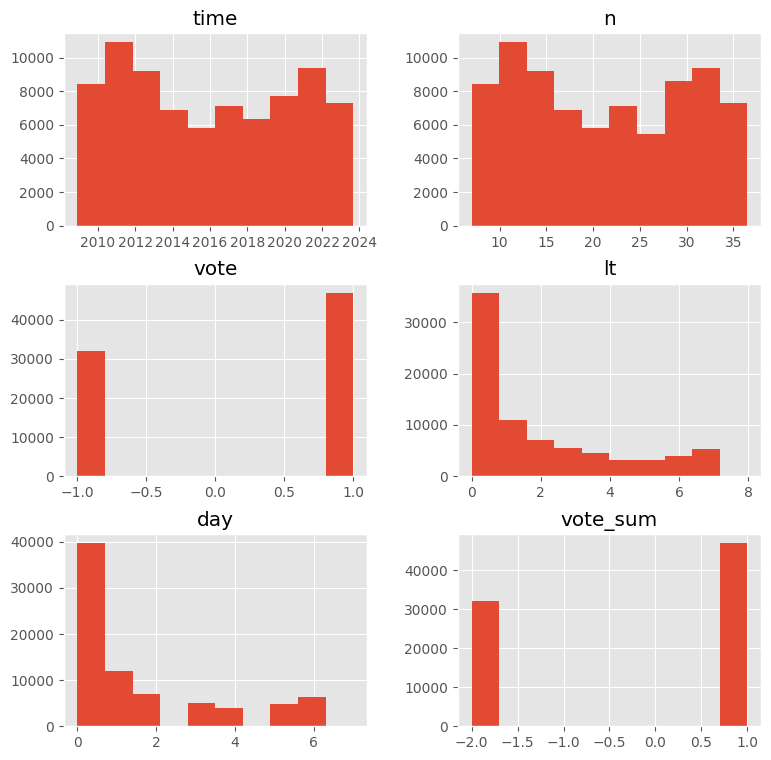

In [36]:
votes.hist(figsize=(9,9))
plt.show()

Так как проведение выборов - регулярное явление, количество голосов во времени и по выборам (n) распределяется схожим образом. `lt` - количество голосов по времени от начала голосования. Видно, что люди в осномном голосуют в первые сутки.

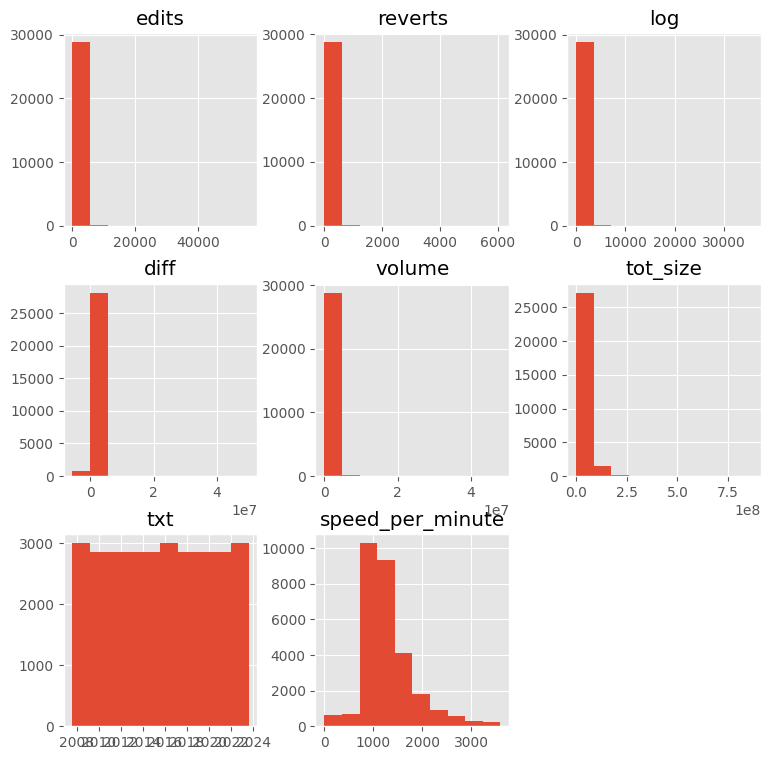

In [37]:
stats.hist(figsize=(9,9))
plt.show()

в первых 6 графиках очевидно есть выбросы больших значений. Посмотрим на распределения подробнее

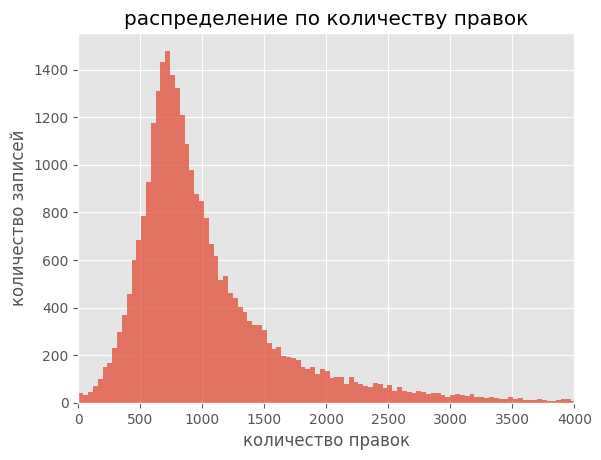

In [38]:
sns.histplot(stats['edits'])
plt.title('распределение по количеству правок')
plt.xlabel('количество правок')
plt.ylabel('количество записей')
plt.xlim(0,4000)
plt.show()

Распределение по правкам похоже на нормальное, с большим количеством выбросов

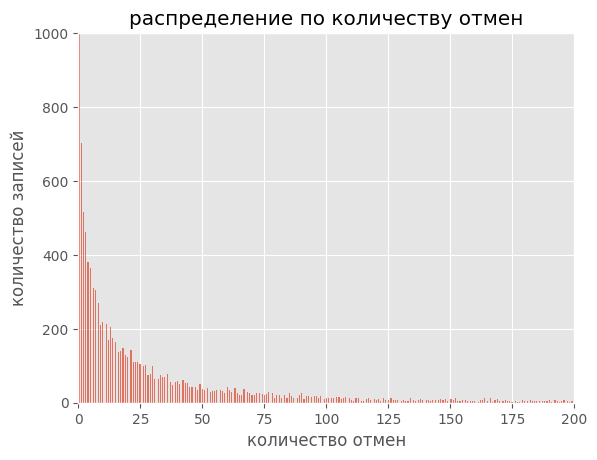

In [39]:
sns.histplot(stats['reverts'])
plt.title('распределение по количеству отмен')
plt.xlabel('количество отмен')
plt.ylabel('количество записей')
plt.xlim(0,200)
plt.ylim(0,1000)
plt.show()

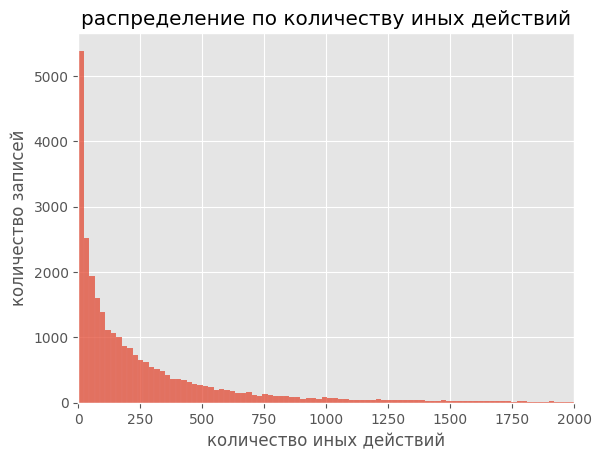

In [40]:
sns.histplot(stats['log'])
plt.title('распределение по количеству иных действий')
plt.xlabel('количество иных действий')
plt.ylabel('количество записей')
plt.xlim(0,2000)
plt.show()

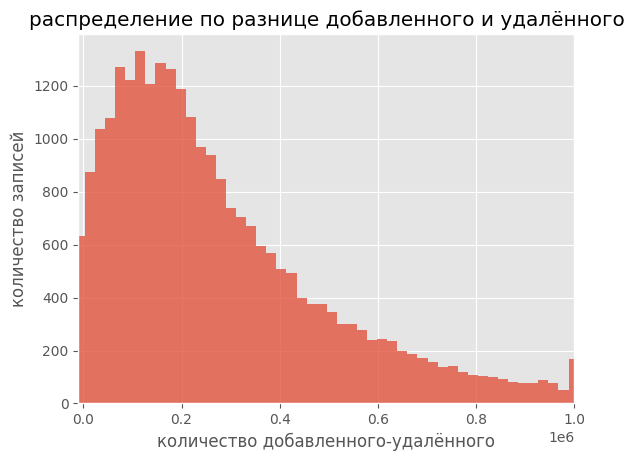

In [41]:
sns.histplot(stats['diff'])
plt.title('распределение по разнице добавленного и удалённого')
plt.xlabel('количество добавленного-удалённого')
plt.ylabel('количество записей')
plt.xlim(-10000,1000000)
plt.show()


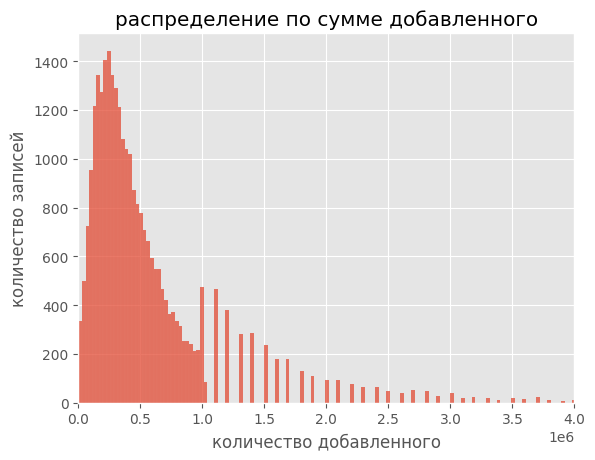

In [42]:
sns.histplot(stats['volume'])
plt.title('распределение по сумме добавленного')
plt.xlabel('количество добавленного')
plt.ylabel('количество записей')
plt.xlim(0,4000000)
plt.show()

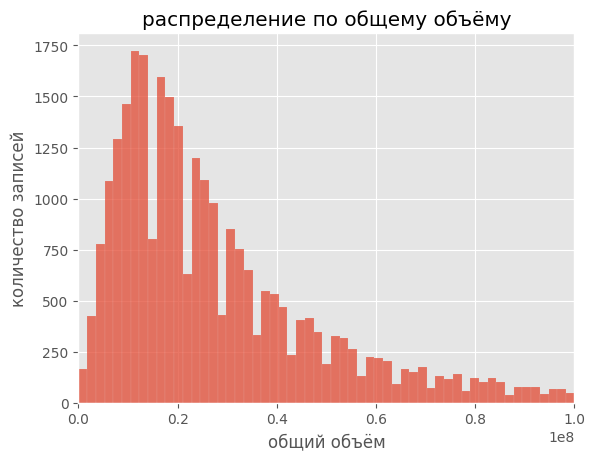

In [43]:
sns.histplot(stats['tot_size'])
plt.title('распределение по общему объёму')
plt.xlabel('общий объём')
plt.ylabel('количество записей')
plt.xlim(0,100000000)
plt.show()

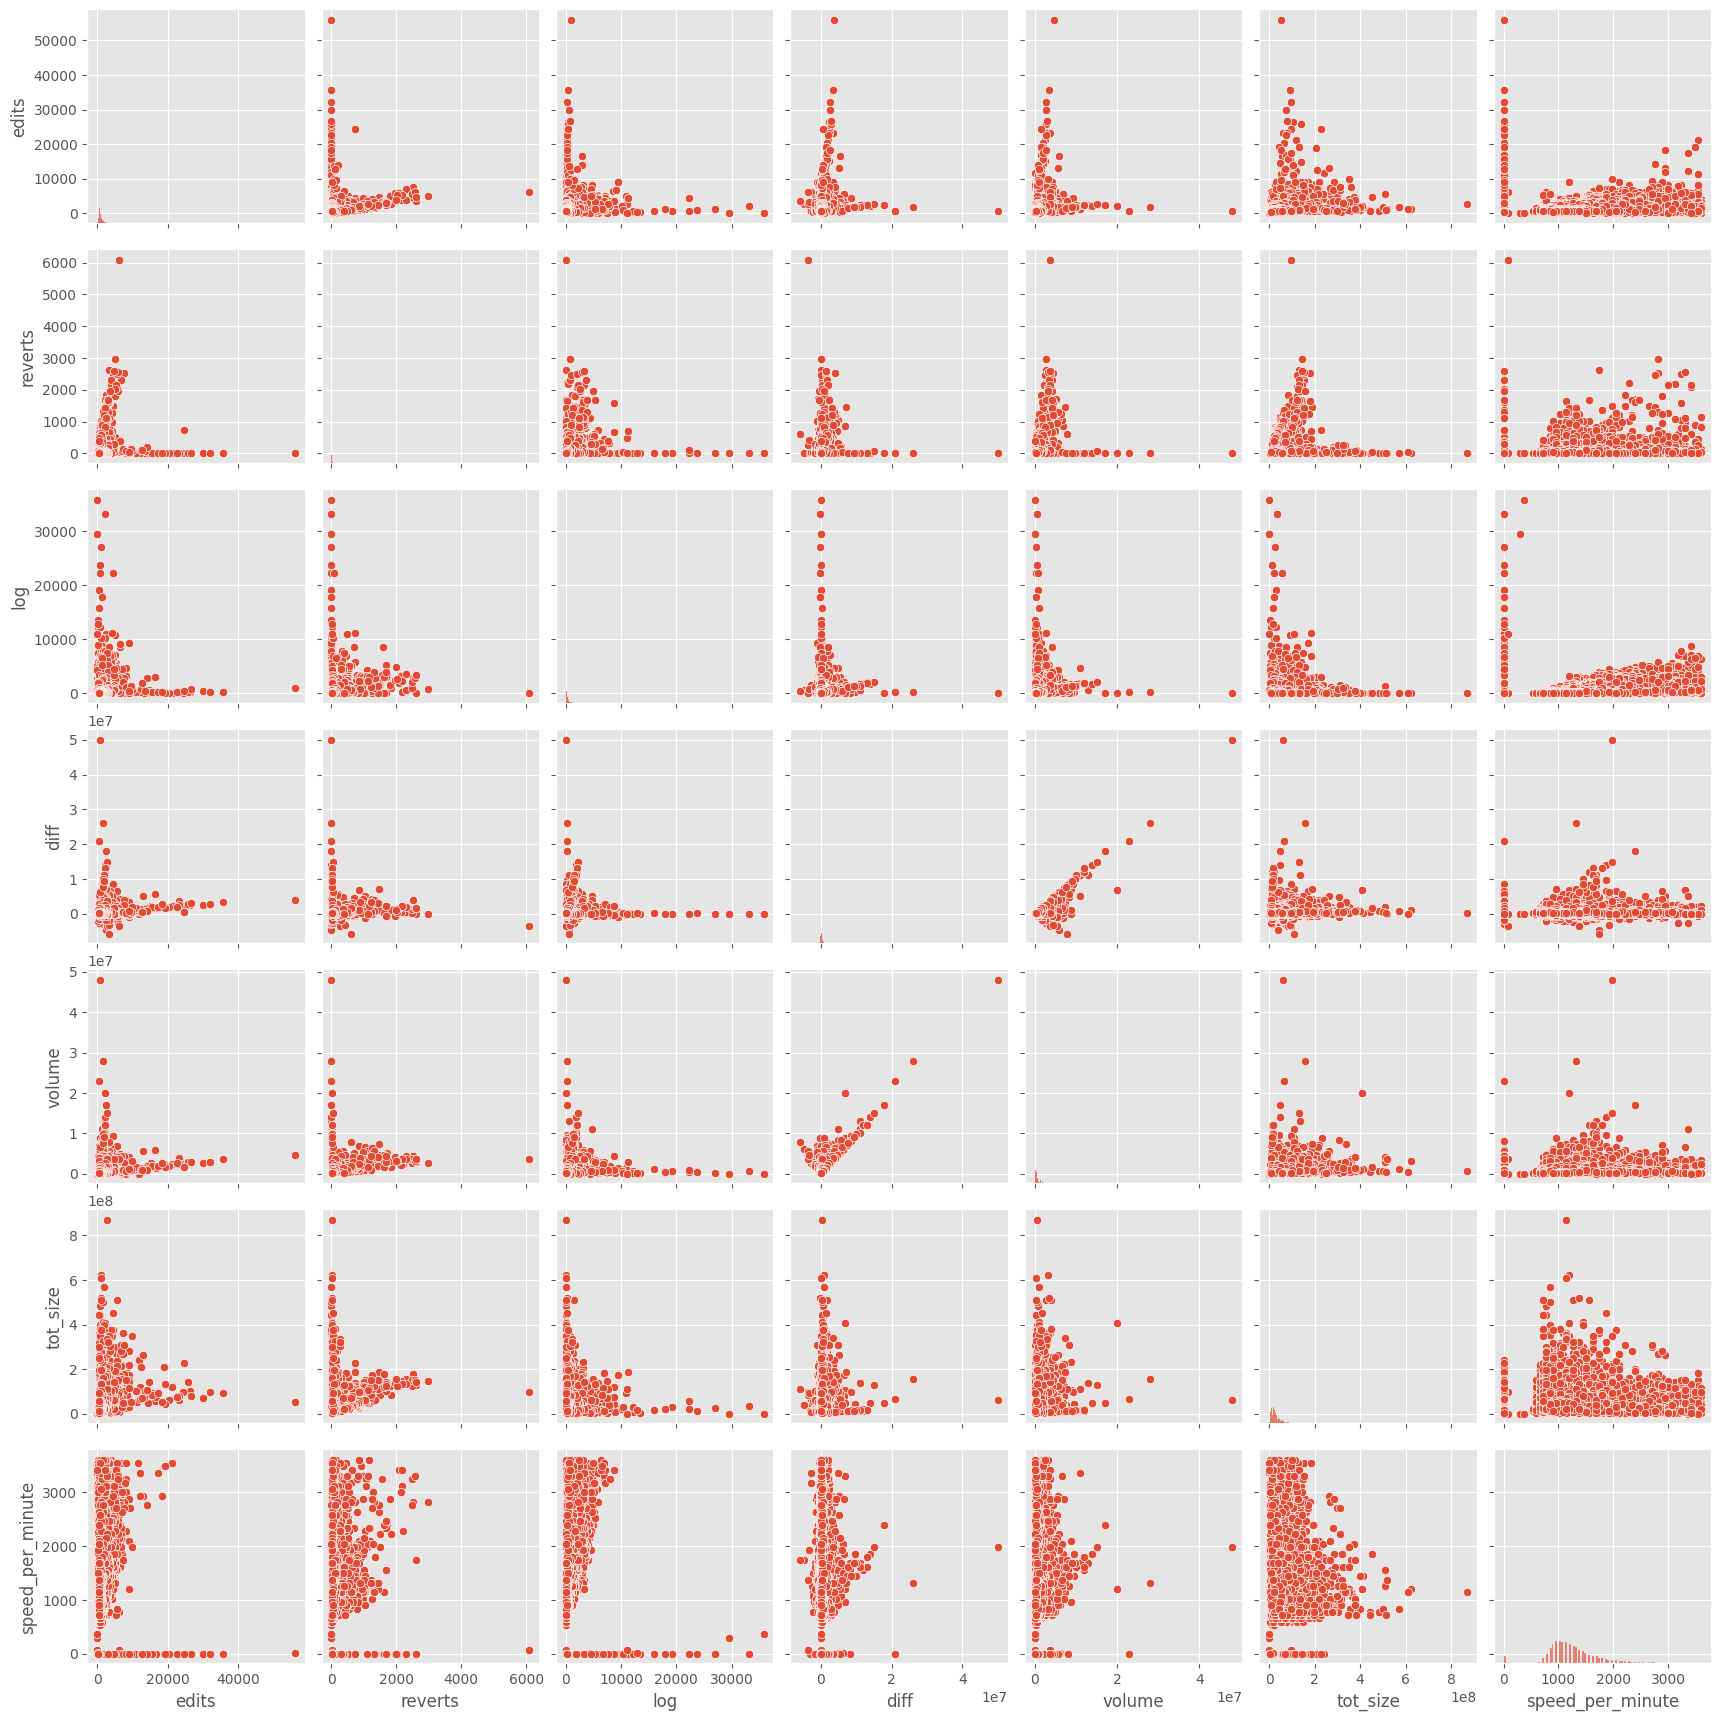

In [44]:
# посмотрим на пары
sns.pairplot(stats)
plt.show()

Корреляций достаточно мало, однако видно, что некоторые значения можно использовать как основные, так как другие схожи по распределению. Например, `volume` и `edits` можно учитывать, а `diff` и `reverts` - опустить.

## RFM

- проведём RFM-сегментацию юзеров
  - Recency — давность — когда совершал последнее записанное действие
  - Frequency — частота — как часто голосует 
  - Monetary — сумма затрат — сколько отдал голосов 


In [45]:
# зададим текущую дату, от неё будем смотреть Recency
PRESENT = dt.datetime(2023,9,13)

In [46]:
# группируем по голосующим
rfm = votes.groupby('voter').agg(
    recency = pd.NamedAgg(column='time', aggfunc=lambda time: (PRESENT - time.max()).days),
    frequency = pd.NamedAgg(column='n', aggfunc=lambda n: n.nunique()),
    monetary = pd.NamedAgg(column='vote', aggfunc= 'count')
)

rfm.head(10)


,recency,frequency,monetary
voter,,,
$toic,3941,2,27
-PhoeniX-,407,2,15
1.b2-b4,197,3,15
11235levap81321,1318,1,5
1677venzel gottorpskij,39,4,19
16relivi,2641,1,7
1Goldberg2,774,9,91
1yurok,3758,1,9
22mirbymirbymirby,406,1,1


In [47]:
# для вычисления RFM Score разобъём столбцы на 5 категорий
rfm['R_Score'] = pd.cut(rfm['recency'], bins=5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.cut(rfm['frequency'], bins=5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.cut(rfm['monetary'], bins=5, labels=[1,2,3,4,5])

rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# RFM_Score - сумма трёх оценок
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

rfm.head(10)

,recency,frequency,monetary,R_Score,F_Score,M_Score,RFM_Score
voter,,,,,,,
$toic,3941,2,27,2,1,1,4
-PhoeniX-,407,2,15,5,1,1,7
1.b2-b4,197,3,15,5,1,1,7
11235levap81321,1318,1,5,4,1,1,6
1677venzel gottorpskij,39,4,19,5,1,1,7
16relivi,2641,1,7,3,1,1,5
1Goldberg2,774,9,91,5,1,2,8
1yurok,3758,1,9,2,1,1,4
22mirbymirbymirby,406,1,1,5,1,1,7


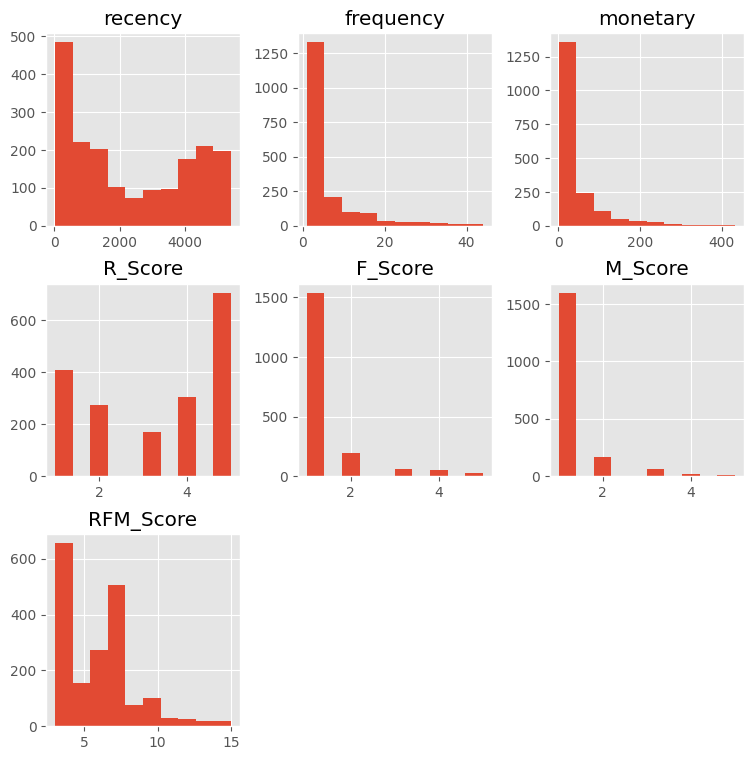

In [48]:
rfm.hist(figsize=(9,9))
plt.show()

В датасете достаточно много пользователей категорий 6-7 по оценке RFM. Это пользователи, участвовавшие в нескольких недавних выборах (511), или участвовавшие в большем количестве выборов ранее (напр. 322). Наибольшее же количество ожидаемо тех, кто голосовал давно и участвовал в малом количестве выборов (111)

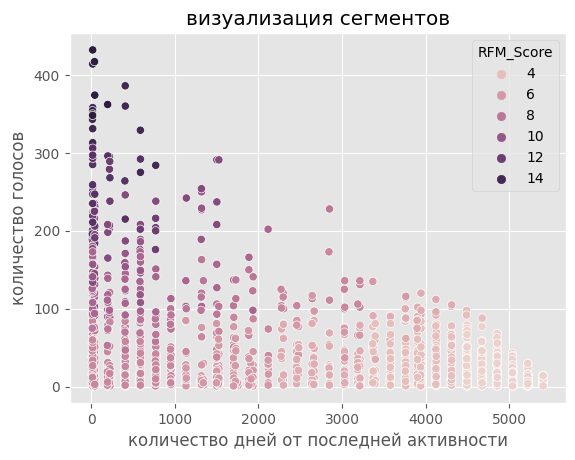

In [49]:
sns.scatterplot(rfm, x='recency', y='monetary', hue='RFM_Score')
plt.title('визуализация сегментов')
plt.xlabel('количество дней от последней активности')
plt.ylabel('количество голосов')
plt.show()

Видим, что люди, которые часто голосуют - в основном активно участвовали в выборах за последние 3 года. В меньшей степени есть люди, которые накопили большое количество голосов и забросили голосования.

# Сводные данные

Объединим данные по пользователям. Для этого сгруппируем `stats` по медианным значениям численных столбцов.

In [50]:
stats.head()

,edits,reverts,log,diff,volume,tot_size,time,speed,user,txt,speed_per_minute
0,1589,0.0,"1,621.0","262,000.0","1,100,000.0","39,000,000.0",3 days 23:00:00,34/h,Altes,2007-08-01,2040
1,1809,0.0,"1,328.0","395,000.0","2,800,000.0","42,000,000.0",5 days 09:00:00,24/h,Obersachse,2007-08-01,1440
2,2734,0.0,0.0,"16,000.0","15,000.0","19,000,000.0",4 days 09:00:00,26/h,Monegasque~ruwiki,2007-08-01,1560
3,2611,0.0,6.0,"278,000.0","350,000.0","43,000,000.0",5 days 15:00:00,19/h,User№101,2007-08-01,1140
4,917,6.0,"1,416.0","154,000.0","1,200,000.0","26,000,000.0",4 days 02:00:00,24/h,Kalan,2007-08-01,1440


In [51]:
stats_grouped = stats.groupby('user').agg({'edits': 'median', 'reverts': 'median', 'log': 'median', 'diff': 'median', 'volume': 'median', 'tot_size': 'median', 'speed_per_minute': 'median', 'time': 'max', 'txt': 'min'})
stats_grouped.head()

,edits,reverts,log,diff,volume,tot_size,speed_per_minute,time,txt
user,,,,,,,,,
-kgoodluck-,"1,006.0",525.0,12.0,"476,000.0","542,000.0","33,000,000.0","1,680.0",1 days 17:00:00,2022-08-01
0lesja Sh,822.0,0.0,3.0,"120,000.0","139,000.0","8,200,000.0","1,380.0",1 days 11:00:00,2012-07-01
0x0F,620.0,0.0,31.0,"48,000.0","66,000.0","17,000,000.0",900.0,1 days 19:00:00,2016-09-01
1.b2-b4,910.5,0.0,14.0,"65,000.0","564,500.0","14,500,000.0",660.0,5 days 13:00:00,2017-03-01
102RB,787.0,0.0,160.0,"379,000.0","425,000.0","9,800,000.0","1,380.0",1 days 16:00:00,2010-10-01


In [52]:
stats_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2541 entries, -kgoodluck- to Ɪ
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   edits             2541 non-null   float64        
 1   reverts           2541 non-null   float64        
 2   log               2541 non-null   float64        
 3   diff              2541 non-null   float64        
 4   volume            2541 non-null   float64        
 5   tot_size          2541 non-null   float64        
 6   speed_per_minute  2541 non-null   float64        
 7   time              2541 non-null   timedelta64[ns]
 8   txt               2541 non-null   datetime64[ns] 
dtypes: datetime64[ns](1), float64(7), timedelta64[ns](1)
memory usage: 198.5+ KB


In [53]:
# объединим датасеты
df = stats_grouped.merge(votes, how='left', left_on='user', right_on='voter')
df.head()

,edits,reverts,log,diff,volume,tot_size,speed_per_minute,time_x,txt,voter,can_vote,time_y,candidate,n,vote,lt,day,vote_sum
0,"1,006.0",525.0,12.0,"476,000.0","542,000.0","33,000,000.0","1,680.0",1 days 17:00:00,2022-08-01,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,822.0,0.0,3.0,"120,000.0","139,000.0","8,200,000.0","1,380.0",1 days 11:00:00,2012-07-01,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,620.0,0.0,31.0,"48,000.0","66,000.0","17,000,000.0",900.0,1 days 19:00:00,2016-09-01,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,910.5,0.0,14.0,"65,000.0","564,500.0","14,500,000.0",660.0,5 days 13:00:00,2017-03-01,1.b2-b4,False,2017-05-27 21:18:00,A.Vajrapani,24.0,1.0,4.9,4.0,1.0
4,910.5,0.0,14.0,"65,000.0","564,500.0","14,500,000.0",660.0,5 days 13:00:00,2017-03-01,1.b2-b4,False,2017-05-27 21:18:00,Акутагава,24.0,1.0,4.9,4.0,1.0


In [54]:
df.describe()

,edits,reverts,log,diff,volume,tot_size,speed_per_minute,time_x,n,vote,lt,day,vote_sum
count,"61,140.0","61,140.0","61,140.0","61,140.0","61,140.0","61,140.0","61,140.0",61140,"59,671.0","59,671.0","59,671.0","59,671.0","59,671.0"
mean,790.5,14.5,319.9,"251,700.5","478,484.8","30,769,102.2","1,219.7",3 days 18:34:58.307163886,20.7,0.2,1.9,1.4,-0.2
std,506.0,68.7,520.5,"310,432.4","362,412.1","29,410,184.5",378.4,1 days 23:52:06.347575680,8.8,1.0,2.1,2.0,1.5
min,0.0,0.0,0.0,"-3,600,000.0",0.0,0.0,1.0,0 days 01:25:00,7.0,-1.0,0.0,0.0,-2.0
25%,592.0,0.0,65.5,"107,000.0","272,000.0","15,000,000.0",960.0,2 days 10:00:00,13.0,-1.0,0.4,0.0,-2.0
50%,723.0,0.0,188.0,"186,000.0","391,000.0","23,500,000.0","1,140.0",3 days 08:00:00,20.0,1.0,0.8,0.0,1.0
75%,878.0,1.5,394.0,"319,000.0","581,000.0","37,000,000.0","1,380.0",4 days 17:00:00,28.5,1.0,2.9,2.0,1.0
max,"14,672.0","6,091.0","32,643.5","21,000,000.0","23,000,000.0","483,000,000.0","3,540.0",19 days 16:00:00,36.5,1.0,8.0,7.0,1.0


По этим данным видно, как могут разделяться сегменты (по квартилям):
- по количеству правок (< 600, < 900, > 900)
- по общему объёму добавленного (< 300 000, < 600 000, > 600 000)
- по скорости внесения правок (< 1000, < 1400, > 1400)
- по времени в системе (< 3 дней, < 5 дней, > 5 дней)

In [55]:
# посмотрим количество голосов за кандидатов в каждых выборах
n_candidate_votes = votes.pivot_table(index=['n'], columns='candidate', values='vote', aggfunc='count', fill_value=0)
votes.pivot_table(index=['n'], columns='candidate', values='vote', margins=True, aggfunc='count', fill_value=0)


candidate,A.Vajrapani,Abiyoyo,Adamant.pwn,Agent001,Ailbeve,Akim Dubrow,Alex Alex Lep,Alexander Roumega,Alexandrov,Alexei Kopylov,...,Хмельницкий Константин,Цезарь Валентиниан,ШаманСемен,Юлия 70,Юрий Владимирович Л.,Юрий Педаченко,‎Alexei Kopylov,‎AndyVolykhov,‎Lesless,All
n,,,,,,,,,,,,,,,,,,,,,
7.0,0,0,0,127,0,0,0,0,134,0,...,0,0,0,0,0,0,0,0,0,1952
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2635
9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3861
10.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3545
11.0,0,162,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3672
12.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3680
13.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,209,0,0,0,2965
14.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2551
15.0,205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2776


In [56]:
# посмотрим количество голосов за кандидатов в каждых выборах, посмотрим разницу положительных и отрицательных
n_candidate_votes = votes.pivot_table(index=['n'], columns='candidate', values='vote', aggfunc='sum', fill_value=0)
votes.pivot_table(index=['n'], columns='candidate', values='vote', margins=True, aggfunc='sum', fill_value=0)

candidate,A.Vajrapani,Abiyoyo,Adamant.pwn,Agent001,Ailbeve,Akim Dubrow,Alex Alex Lep,Alexander Roumega,Alexandrov,Alexei Kopylov,...,Хмельницкий Константин,Цезарь Валентиниан,ШаманСемен,Юлия 70,Юрий Владимирович Л.,Юрий Педаченко,‎Alexei Kopylov,‎AndyVolykhov,‎Lesless,All
n,,,,,,,,,,,,,,,,,,,,,
7.0,0,0,0,-101,0,0,0,0,-28,0,...,0,0,0,0,0,0,0,0,0,358
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,837
9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,785
10.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,707
11.0,0,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,318
12.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,424
13.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,61,0,0,0,459
14.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,657
15.0,65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,108


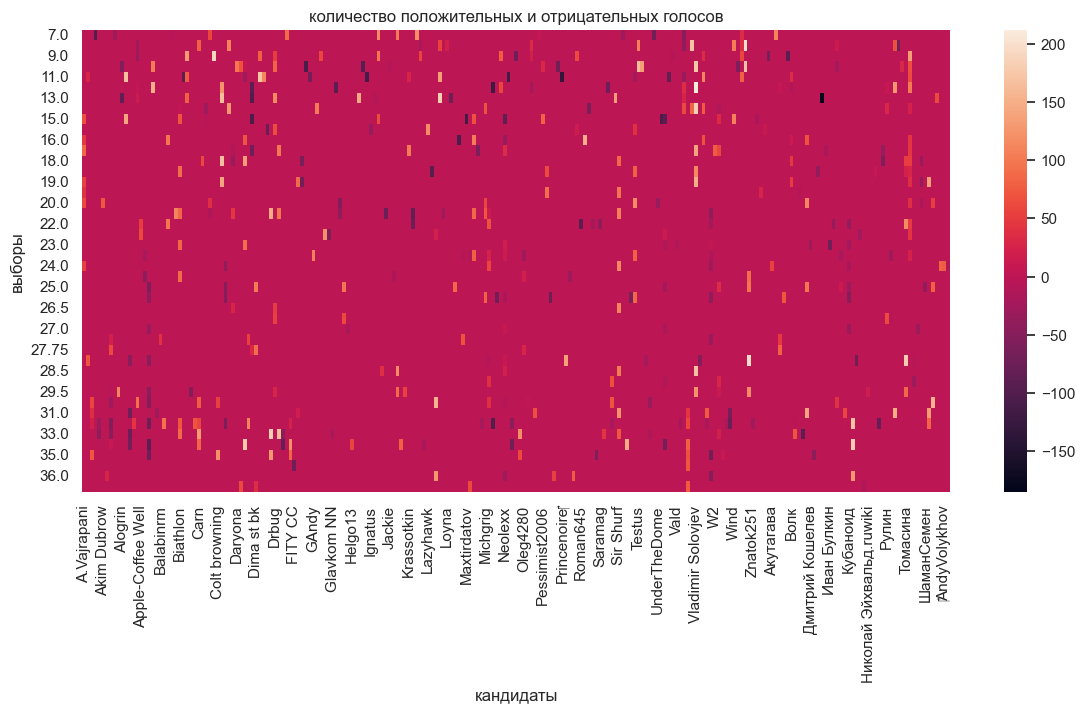

In [57]:
sns.set(rc={'figure.figsize':(14,6)})
sns.heatmap(n_candidate_votes)
plt.title('количество положительных и отрицательных голосов')
plt.xlabel('кандидаты')
plt.ylabel('выборы')
plt.show()

График показывает какие из кандидатов получали большое количество положительных голосов, а какие - отрицательных, в каждых проведённых выборах

In [58]:
# как получали голоса в течение хода голосования
votes.pivot_table(index=['n', 'day'], columns='candidate', values='vote', margins=True, aggfunc='count', fill_value=0)

candidate  A.Vajrapani  Abiyoyo  Adamant.pwn  Agent001  Ailbeve  Akim Dubrow  \
n    day                                                                       
7.0  0               0        0            0        69        0            0   
     1               0        0            0        23        0            0   
     2               0        0            0         9        0            0   
     3               0        0            0         3        0            0   
     4               0        0            0         6        0            0   
...                ...      ...          ...       ...      ...          ...   
36.5 3               0        0            0         0        0            0   
     4               0        0            0         0        0            0   
     5               0        0            0         0        0            0   
     6               0        0            0         0        0            0   
All               1339      580          660       127      253          175   

candidate  Alex Alex Lep  Alexander Roumega  Alexandrov  Alexei Kopylov  ...  \
n    day                                                                 ...   
7.0  0                 0                  0          73               0  ...   
     1                 0                  0          23               0  ...   
     2                 0                  0           9               0  ...   
     3                 0                  0           8               0  ...   
     4                 0                  0           5               0  ...   
...                  ...                ...         ...             ...  ...   
36.5 3                 0                  0           0               0  ...   
     4                 0                  0           0               0  ...   
     5                 0                  0           0               0  ...   
     6                 0                  0           0               0  ...   
All                  131                987         134             144  ...   

candidate  Хмельницкий Константин  Цезарь Валентиниан  ШаманСемен  Юлия 70  \
n    day                                                                     
7.0  0                          0                   0           0        0   
     1                          0                   0           0        0   
     2                          0                   0           0        0   
     3                          0                   0           0        0   
     4                          0                   0           0        0   
...                           ...                 ...         ...      ...   
36.5 3                          0                   0           0        0   
     4                          0                   0           0        0   
     5                          0                   0           0        0   
     6                          0                   0           0        0   
All                            97                 511          68      553   

candidate  Юрий Владимирович Л.  Юрий Педаченко  ‎Alexei Kopylov  \
n    day                                                           
7.0  0                        0               0                0   
     1                        0               0                0   
     2                        0               0                0   
     3                        0               0                0   
     4                        0               0                0   
...                         ...             ...              ...   
36.5 3                        0               0                0   
     4                        0               0                0   
     5                        0               0                0   
     6                        0               0                0   
All                         434             209              129   

candidate  ‎AndyVo

In [59]:
# посмотрим на общее распределение голосов
voter_candidate_votes = votes.pivot_table(index=['voter'], columns='candidate', values='vote', fill_value=0)

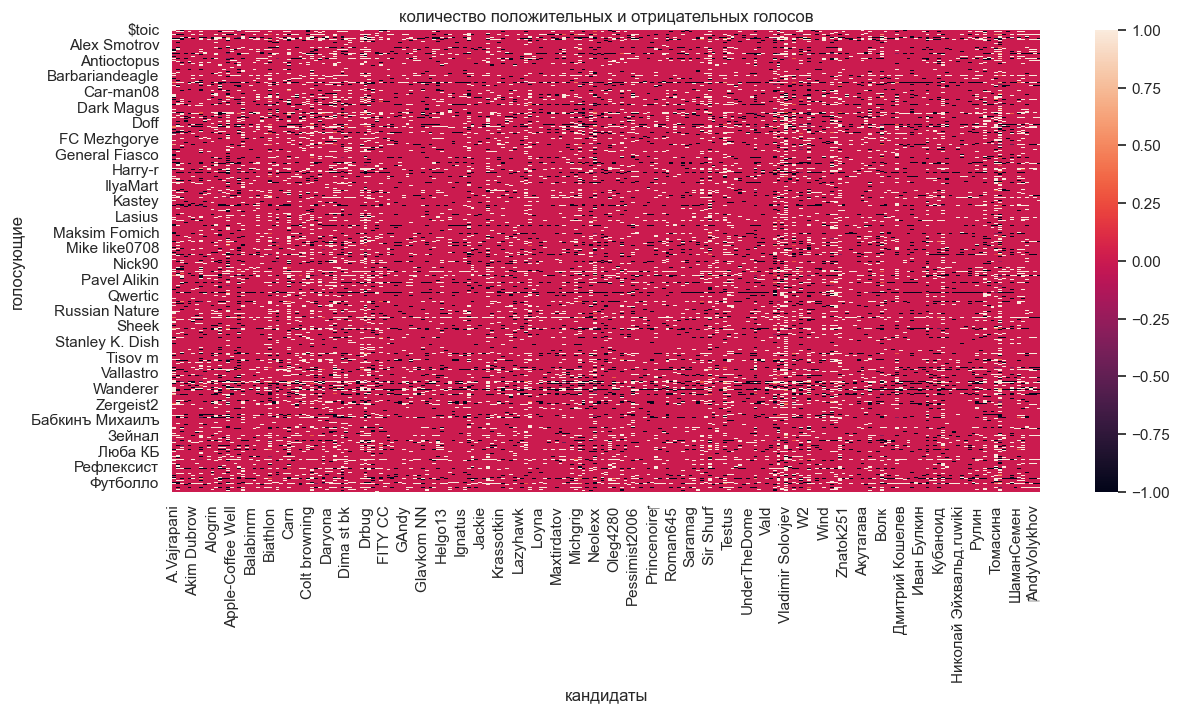

In [60]:
sns.set(rc={'figure.figsize':(14,6)})
sns.heatmap(voter_candidate_votes)
plt.title('количество положительных и отрицательных голосов')
plt.xlabel('кандидаты')
plt.ylabel('голосующие')
plt.show()

Видим, что есть кандидаты, за которых большинство пользователей голосует положително (белые вертикальные полосы). Также есть пользователи, которые отдают много положительных голосов большинству кандидатов, но есть и обратная картина, где пользователи отдают в основном отрицательные голоса кандидатам (горизонтальные чёрные полосы)

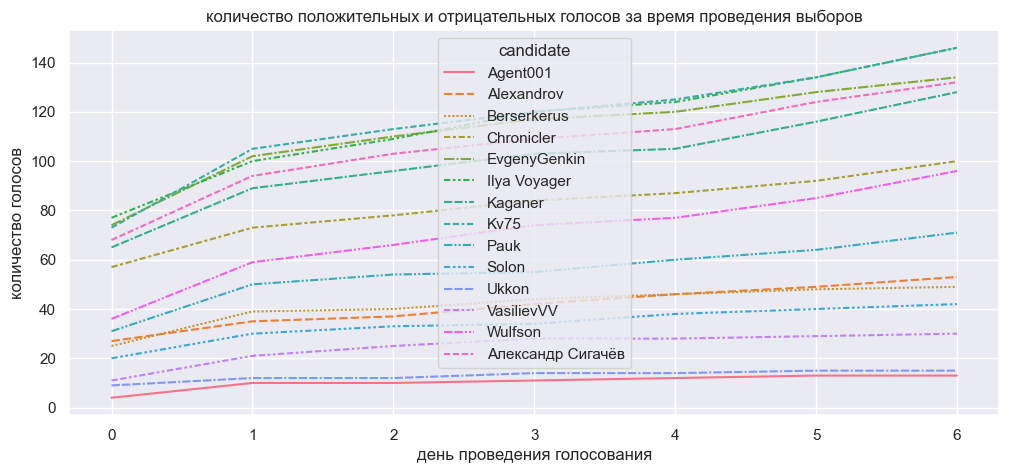

In [61]:
# пример динамики выборов по дням
temp = votes.query('n == 7.0 and vote == 1').pivot_table(index=['day'], columns='candidate', values='vote', aggfunc='count', fill_value=0)
temp = temp.cumsum()
sns.set(rc={'figure.figsize':(12,5)})
sns.lineplot(data=temp)
plt.title('количество положительных и отрицательных голосов за время проведения выборов')
plt.xlabel('день проведения голосования')
plt.ylabel('количество голосов')
plt.show()

Большинство выборов в течение недели проходят относительно спокойно и без замен лидеров и аутсайдеров. Кажется, что основные события происходят в первый день.

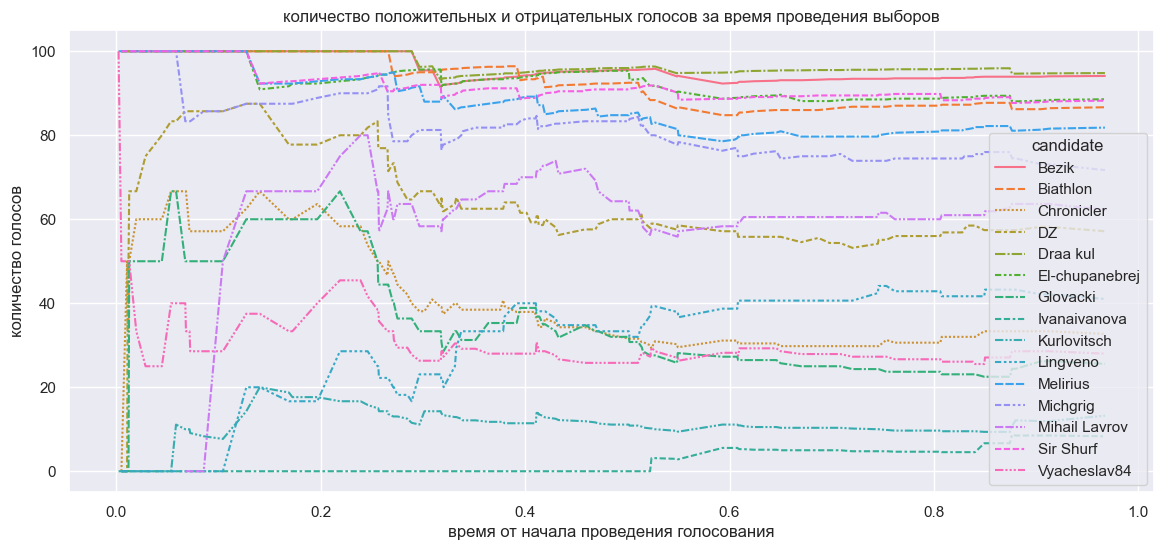

In [62]:
sns.set(rc={'figure.figsize':(14,6)})
# динамика первого дня по всем выборам
#for i in votes['n'].unique():
#    temp = votes.query('n == @i and vote == 1 and lt < 1').pivot_table(index=['lt'], columns='candidate', values='vote', aggfunc='count', fill_value=0).cumsum()
#    temp2 = votes.query('n == @i and lt < 1').pivot_table(index=['lt'], columns='candidate', values='vote', aggfunc='count', fill_value=0).cumsum()
    
#    for c in temp.columns:
#        temp[c] = temp[c]/temp2[c]*100
#    plt.figure(i)
#    sns.lineplot(data=temp).set(title=i)

# выведем одни, чтобы не перегружать вывод
i=21.0
temp = votes.query('n == @i and vote == 1 and lt < 1').pivot_table(index=['lt'], columns='candidate', values='vote', aggfunc='count', fill_value=0).cumsum()
temp2 = votes.query('n == @i and lt < 1').pivot_table(index=['lt'], columns='candidate', values='vote', aggfunc='count', fill_value=0).cumsum()
    
for c in temp.columns:
    temp[c] = temp[c]/temp2[c]*100
plt.figure(i)
sns.lineplot(data=temp).set(title=i)
plt.title('количество положительных и отрицательных голосов за время проведения выборов')
plt.xlabel('время от начала проведения голосования')
plt.ylabel('количество голосов')
plt.show()

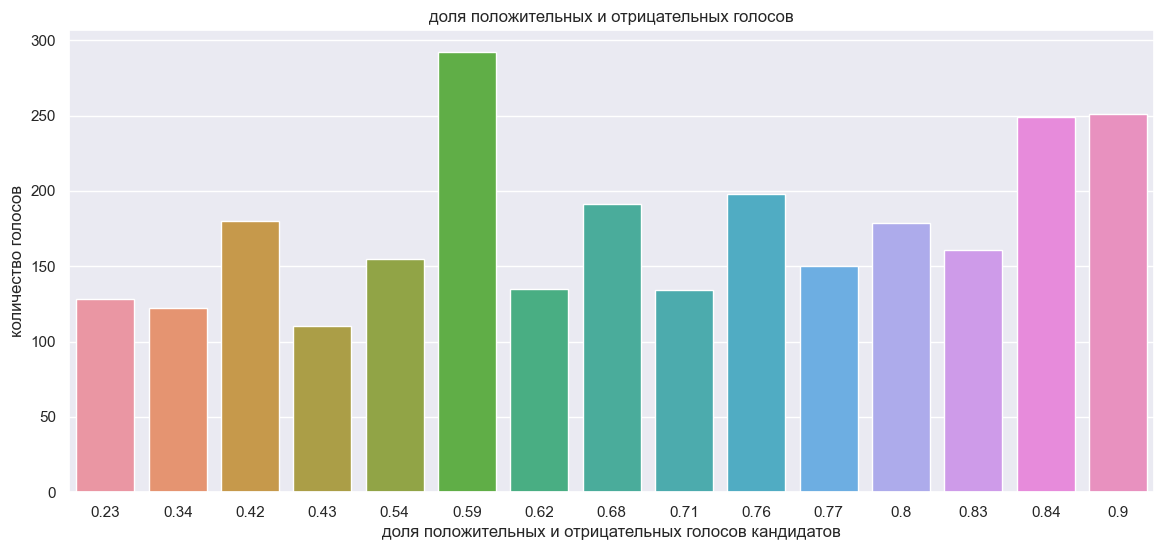

In [63]:
# активность первого дня по  выборам 8.0

temp = votes.query('n == 8.0 and vote == 1').groupby(['candidate']).agg(positive = ('vote', sum))
temp2 = votes.query('n == 8.0 ').groupby(['candidate'])['vote'].agg('count')

temp = temp.merge(temp2, on='candidate')
temp['pct'] = round(temp['positive']/temp['vote'],2)
temp = temp.groupby('pct').agg('sum')

sns.barplot(data=temp, x=temp.index, y="vote")
plt.title('доля положительных и отрицательных голосов')
plt.xlabel('доля положительных и отрицательных голосов кандидатов')
plt.ylabel('количество голосов')

plt.show()

Видим, что активность высокая в голосовании за лидеров и там, где кандидаты находятся на грани 2/3 доли положительных голосов

In [64]:
#sns.set(rc={'figure.figsize':(14,6)})
# # активность первого дня по всем выборам

#for i in votes['n'].unique():
#    temp = votes.query('n == @i and vote == 1').groupby(['candidate']).agg(positive = ('vote', sum))
#    temp2 = votes.query('n == @i').groupby(['candidate'])['vote'].agg('count')

#    temp = temp.merge(temp2, on='candidate')
#    temp['pct'] = round(temp['positive']/temp['vote'],2)
#    temp = temp.groupby('pct').agg('sum')

    
#    plt.figure(i)
#    sns.barplot(data=temp, x=temp.index, y="vote").set(title=i)

#plt.show()


<a id="conclusions"></a>
# Выводы

## Мы исследовали данные на уснове двух датасетов.

Датасет `votes` достаточно чистый, без дубликатов и пустых значений. 
- Обработали и подготовили данные, посчитали целые дни голосований и добавили столбец для расчёта доли положительных голосов. 
- Также проверили уникальные значения.

1862 голосующих (voter)
227 кандидатов (candidate)

Провели обработку данных в `stats`. Переименовали столбцы, избавились от пропусков. Привели типы данных - время, там где оно должно быть, и `float` и `int` там, где они были строками

2541 пользователь (user)

## Провели исследовательский анализ данных

- Так как проведение выборов - регулярное явление, количество голосов во времени и по выборам (n) распределяется схожим образом. `lt` - количество голосов по времени от начала голосования. Видно, что люди в осномном голосуют в первые сутки.
- В статистике по контенту корреляций достаточно мало, однако видно, что некоторые значения можно использовать как основные, так как другие схожи по распределению. Например, `volume` и `edits` можно учитывать, а `diff` и `reverts` - опустить.

### Сделали RFM сегментацию по голосующим

- В датасете достаточно много пользователей категорий 6-7 по оценке RFM. Это пользователи, участвовавшие в нескольких недавних выборах (511), или участвовавшие в большем количестве выборов ранее (напр. 322). Наибольшее же количество ожидаемо тех, кто голосовал давно и участвовал в малом количестве выборов (111)
- Видим, что люди, которые часто голосуют - в основном активно участвовали в выборах за последние 3 года. В меньшей степени есть люди, которые накопили большое количество голосов и забросили голосования.

### Объединили два датасета по пользователям

- По этим данным видно, как могут разделяться сегменты (по квартилям):
  - по количеству правок (< 600, < 900, > 900)
  - по общему объёму добавленного (< 300 000, < 600 000, > 600 000)
  - по скорости внесения правок (< 1000, < 1400, > 1400)
  - по времени в системе (< 3 дней, < 5 дней, > 5 дней)

### Посмотрели на распределение голосов за всё время и по каждым выборам
- Видим, что есть кандидаты, за которых большинство пользователей голосует положително (белые вертикальные полосы). Также есть пользователи, которые отдают много положительных голосов большинству кандидатов, но есть и обратная картина, где пользователи отдают в основном отрицательные голоса кандидатам (горизонтальные чёрные полосы)
- Большинство выборов в течение недели проходят относительно спокойно и без замен лидеров и аутсайдеров. Кажется, что основные события происходят в первый день.
- Видим, что активность высокая в голосовании за лидеров и там, где кандидаты находятся на грани 2/3 доли положительных голосов